In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from tqdm import tqdm
from data.dataset import DiffusionDataset, get_dataloader, sin_1d
from utils.diffusion import Diffusion, cosine_schedule
from models.mlp import ScoreModel
from models.train import train_score_mlp

# Generate data

In [34]:
seed = 42
n_samples = 1000
dataset = DiffusionDataset(dataset_name='sin_1d', n_samples=n_samples, seed=seed)

In [35]:
# raw dataset is in np.ndarray
print(dataset[0])
print(dataset.x[:5])
print(dataset.y[:5])

{'x': 0.37454012, 'y': 1.7878048}
[0.37454012 0.9507143  0.7319939  0.5986585  0.15601864]
[1.7878048  0.13477731 0.145768   0.63701797 1.8888878 ]


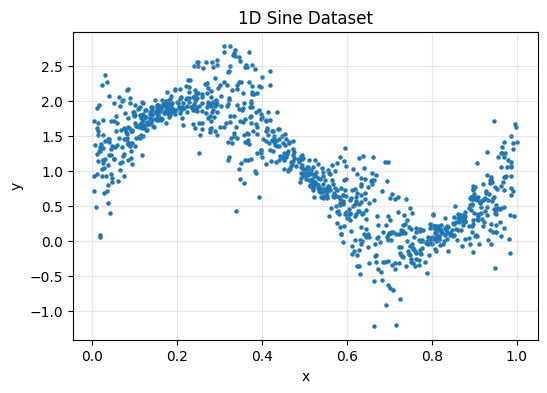

In [36]:
plt.figure(figsize=(6, 4))
plt.grid(alpha=0.3)
plt.xlabel('x')
plt.ylabel('y')
plt.title('1D Sine Dataset')
plt.scatter(dataset.x, dataset.y, s=5)

In [37]:
train_loader, test_loader, val_loader = get_dataloader(dataset, shuffle=True, batch_size=32)
print(f"Total number of samples in training set: {len(train_loader.dataset)}")
train_loader.dataset[0]

Total number of samples in training set: 800


{'x': 0.89552325, 'y': 0.59890693}

In [38]:
batch = next(iter(train_loader))
print(f"Number of samples in each batch: {batch['x'].shape[0]}")
print(f"Number of batches: {len(train_loader)}")
# batch is now in torch.Tensor, input to diffusion model
print(batch)
print(batch['y'].shape)

Number of samples in each batch: 32
Number of batches: 25
{'x': tensor([0.2774, 0.6409, 0.0912, 0.1608, 0.2236, 0.1072, 0.8871, 0.6323, 0.8106,
        0.3095, 0.5495, 0.2123, 0.8996, 0.9472, 0.0465, 0.8094, 0.4625, 0.5956,
        0.0233, 0.2932, 0.7296, 0.4087, 0.5117, 0.8671, 0.9004, 0.0452, 0.1079,
        0.3689, 0.6514, 0.3979, 0.5222, 0.1849]), 'y': tensor([ 1.5497,  1.0422,  1.5753,  1.8498,  2.0341,  1.4865,  0.0410,  0.6621,
         0.0372,  2.2709,  0.7011,  1.7555,  0.6677,  0.6215,  0.9047, -0.0064,
         1.0230,  1.3197,  2.2293,  1.9546,  0.1154,  1.4261,  0.9745,  0.3273,
         0.6158,  1.3156,  1.8775,  1.3880,  0.5491,  1.7394,  0.8028,  1.8859])}
torch.Size([32])


# Diffusion process

torch.Size([1001])
torch.Size([1001])
torch.Size([1001])
tensor(1.) tensor(0.0010)
tensor(0.) tensor(0.9990)
tensor(1.) tensor(1.9110e-15)


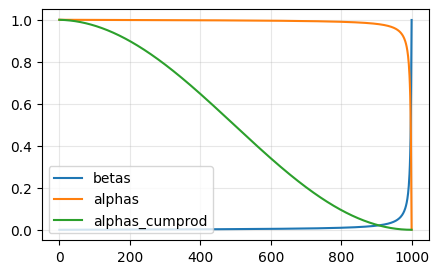

In [9]:
# check the schedules
betas, alphas, alphas_cumprod = cosine_schedule(1000)
print(betas.shape)
print(alphas.shape)
print(alphas_cumprod.shape)

print(alphas[0], alphas[-1])
print(betas[0], betas[-1])
print(alphas_cumprod[0], alphas_cumprod[-1])

plt.figure(figsize=(5, 3))
plt.grid(alpha=0.3)
plt.plot(betas, label='betas')
plt.plot(alphas, label='alphas')
plt.plot(alphas_cumprod, label='alphas_cumprod')
plt.legend(loc='lower left')

torch.Size([1000])
torch.Size([1000])
torch.Size([1000])


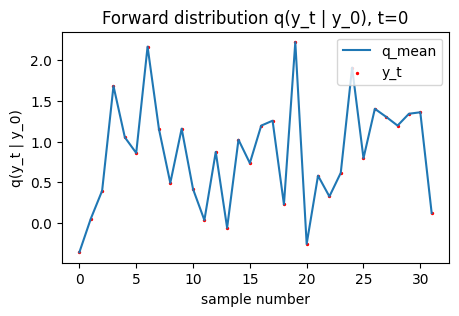

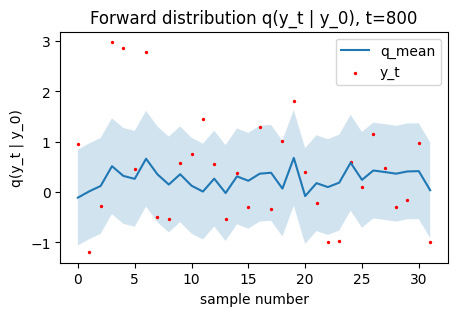

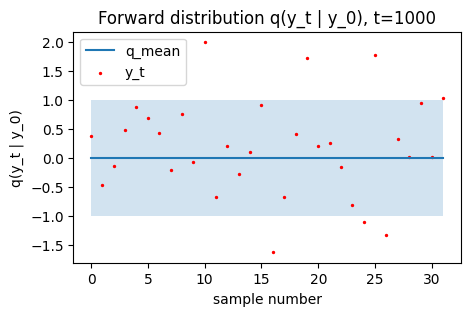

torch.Size([32])
torch.Size([32])


In [10]:
d = Diffusion(T=1000)
print(d.posterior_variance.shape)
print(d.posterior_mean_coef1.shape)
print(d.posterior_mean_coef2.shape)

y0 = batch['y']

plt.figure(figsize=(5, 3))
t = 0
q_mean, q_var = d.forward_q(y0, t)
# sample y_t from q(y_t | y_0)
noise = torch.randn_like(y0)
y_t = d.q_sample(y0, t, noise)
plt.title(f'Forward distribution q(y_t | y_0), t={t}')
plt.xlabel('sample number')
plt.ylabel('q(y_t | y_0)')
plt.plot(q_mean, label='q_mean')
# fill between standard deviation
plt.fill_between(range(len(q_mean)), q_mean - q_var**0.5, q_mean + q_var**0.5, alpha=0.2)
plt.scatter(range(len(y_t)), y_t, s=2, c='r', label='y_t')
plt.legend()
plt.show()

plt.figure(figsize=(5, 3))
t = 800
q_mean, q_var = d.forward_q(y0, t)
# sample y_t from q(y_t | y_0)
noise = torch.randn_like(y0)
y_t = d.q_sample(y0, t, noise)
plt.title(f'Forward distribution q(y_t | y_0), t={t}')
plt.xlabel('sample number')
plt.ylabel('q(y_t | y_0)')
plt.plot(q_mean, label='q_mean')
# fill between standard deviation
plt.fill_between(range(len(q_mean)), q_mean - q_var**0.5, q_mean + q_var**0.5, alpha=0.2)
plt.scatter(range(len(y_t)), y_t, s=2, c='r', label='y_t')
plt.legend()
plt.show()

plt.figure(figsize=(5, 3))
t = 1000
q_mean, q_var = d.forward_q(y0, t)
# sample y_t from q(y_t | y_0)
noise = torch.randn_like(y0)
y_t = d.q_sample(y0, t, noise)
plt.title(f'Forward distribution q(y_t | y_0), t={t}')
plt.xlabel('sample number')
plt.ylabel('q(y_t | y_0)')
plt.plot(q_mean, label='q_mean')
# fill between standard deviation
plt.fill_between(range(len(q_mean)), q_mean - q_var**0.5, q_mean + q_var**0.5, alpha=0.2)
plt.scatter(range(len(y_t)), y_t, s=2, c='r', label='y_t')
plt.legend()
plt.show()

print(q_mean.shape)
print(q_var.shape)


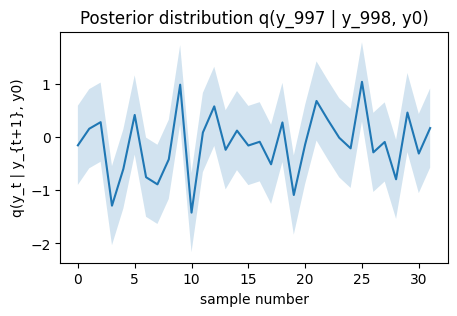

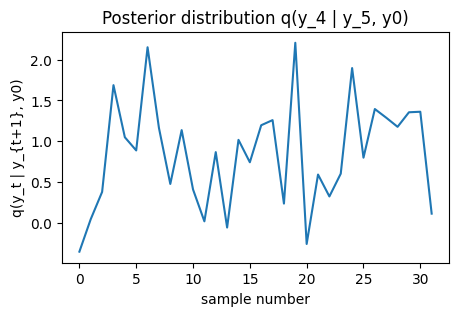

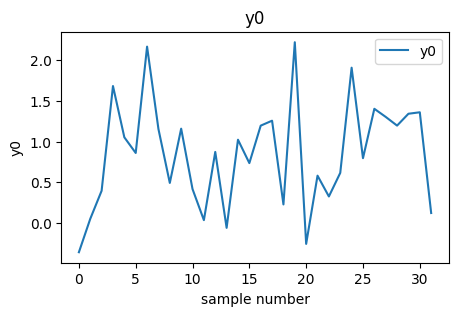

In [11]:
# sample y_T from q(y_T | y_0)
t = 998
q_mean, q_var = d.forward_q(y0, t) # get the forward distribution q(y_t | y_0)
y_t = q_mean + torch.randn_like(q_mean) * torch.sqrt(q_var) # sample y_T from q(y_t | y_0)
q_posterior_mean, q_posterior_var = d.reverse_q(y0, y_t, t-1)
plt.figure(figsize=(5, 3))
plt.title(f'Posterior distribution q(y_{t-1} | y_{t}, y0)')
plt.xlabel('sample number')
plt.ylabel('q(y_t | y_{t+1}, y0)')
plt.plot(q_posterior_mean, label='q_posterior_mean')
# fill between standard deviation
plt.fill_between(range(len(q_posterior_mean)), q_posterior_mean - q_posterior_var**0.5, q_posterior_mean + q_posterior_var**0.5, alpha=0.2)

t = 5
q_mean, q_var = d.forward_q(y0, t) # get the forward distribution q(y_t | y_0)
y_t = q_mean + torch.randn_like(q_mean) * torch.sqrt(q_var) # sample y_T from q(y_t | y_0)
q_posterior_mean, q_posterior_var = d.reverse_q(y0, y_t, t-1)
plt.figure(figsize=(5, 3))
plt.title(f'Posterior distribution q(y_{t-1} | y_{t}, y0)')
plt.xlabel('sample number')
plt.ylabel('q(y_t | y_{t+1}, y0)')
plt.plot(q_posterior_mean, label='q_posterior_mean')
# fill between standard deviation
plt.fill_between(range(len(q_posterior_mean)), q_posterior_mean - q_posterior_var**0.5, q_posterior_mean + q_posterior_var**0.5, alpha=0.2)

# plot the y0
plt.figure(figsize=(5, 3))
plt.title('y0')
plt.xlabel('sample number')
plt.ylabel('y0')
plt.plot(y0, label='y0')
plt.legend()
plt.show()


# Training

In [2]:
seed = 42
n_samples = 4000
dataset = DiffusionDataset(dataset_name='sin_1d', n_samples=n_samples, seed=seed)

# # # create a new dataset with the scaled y
# dataset_scaled = DiffusionDataset(dataset_name='sin_1d', n_samples=n_samples, seed=seed)
# dataset_scaled.y = 2 * (dataset.y - dataset.y.min()) / (dataset.y.max() - dataset.y.min()) - 1

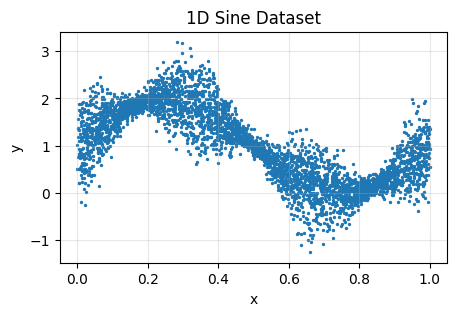

2800
0
1200


In [3]:
plt.figure(figsize=(5, 3))
plt.grid(alpha=0.3)
plt.xlabel('x')
plt.ylabel('y')
plt.title('1D Sine Dataset')
plt.scatter(dataset.x, dataset.y, s=2)
plt.show()

train_loader, test_loader, val_loader = get_dataloader(dataset, shuffle=True, batch_size=32, train_ratio=0.7, val_ratio=0.3)
print(len(train_loader.dataset))
print(len(test_loader.dataset))
print(len(val_loader.dataset))

In [4]:
model, train_loss, val_loss = train_score_mlp(train_loader, val_loader, hidden_dims=[32, 32, 64], epoch_update=10, num_epochs=500, time_steps=1000, learning_rate=1e-4, device_type='cpu', save_path=None)

Epoch 0/500, Train Loss: 0.5515, Val Loss: 0.4669
Epoch 10/500, Train Loss: 0.2809, Val Loss: 0.2290
Epoch 20/500, Train Loss: 0.2493, Val Loss: 0.1941
Epoch 30/500, Train Loss: 0.2383, Val Loss: 0.1703
Epoch 40/500, Train Loss: 0.2233, Val Loss: 0.1924
Epoch 50/500, Train Loss: 0.2289, Val Loss: 0.1898
Epoch 60/500, Train Loss: 0.2085, Val Loss: 0.1716
Epoch 70/500, Train Loss: 0.2265, Val Loss: 0.2080
Epoch 80/500, Train Loss: 0.2065, Val Loss: 0.1808
Epoch 90/500, Train Loss: 0.1957, Val Loss: 0.1894
Epoch 100/500, Train Loss: 0.2143, Val Loss: 0.1945
Epoch 110/500, Train Loss: 0.2127, Val Loss: 0.1776
Epoch 120/500, Train Loss: 0.2215, Val Loss: 0.1803
Epoch 130/500, Train Loss: 0.2044, Val Loss: 0.1787
Epoch 140/500, Train Loss: 0.1958, Val Loss: 0.1637
Epoch 150/500, Train Loss: 0.1937, Val Loss: 0.1713
Epoch 160/500, Train Loss: 0.2165, Val Loss: 0.1948
Epoch 170/500, Train Loss: 0.1864, Val Loss: 0.1792
Epoch 180/500, Train Loss: 0.2036, Val Loss: 0.1686
Epoch 190/500, Train Lo

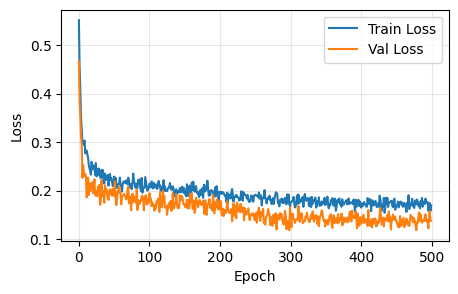

In [5]:
plt.figure(figsize=(5, 3))
plt.grid(alpha=0.3)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.plot(train_loss, label='Train Loss')
plt.plot(val_loss, label='Val Loss')
plt.legend()
plt.show()

In [6]:
def sample_from_model(model, location, num_samples, device):
    y_t = torch.randn(num_samples).to(device)
    x = torch.ones_like(y_t) * location
    diffusion = Diffusion(T=1000, device=device)
    
    for t in range(999, -1, -1):
        t_tensor = torch.ones_like(y_t) * (t+1)
        score = model(x, y_t, t_tensor)
        y_t = (1/torch.sqrt(diffusion.alphas[t+1])) * (y_t - ((1-diffusion.alphas[t+1])/torch.sqrt(1-diffusion.alphas_cumprod[t+1])) * score)
        y_t += torch.randn_like(y_t) * torch.sqrt(diffusion.betas[t+1])
    return y_t

In [7]:
num_locations = 100
num_samples = 100
locations = torch.linspace(0, 1, num_locations)
results = torch.zeros(num_locations,num_samples)
device = torch.device('cpu')

with tqdm(range(num_locations)) as pbar:
    for i, location in enumerate(locations):
        results[i] = sample_from_model(model, location, num_samples, device)
        pbar.update(1)
results = results.detach().numpy()

100%|██████████| 100/100 [00:18<00:00,  5.34it/s]


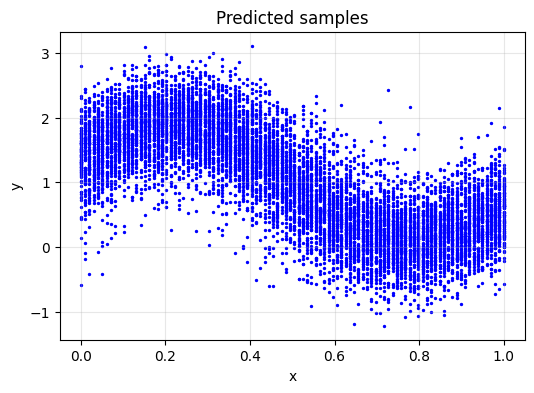

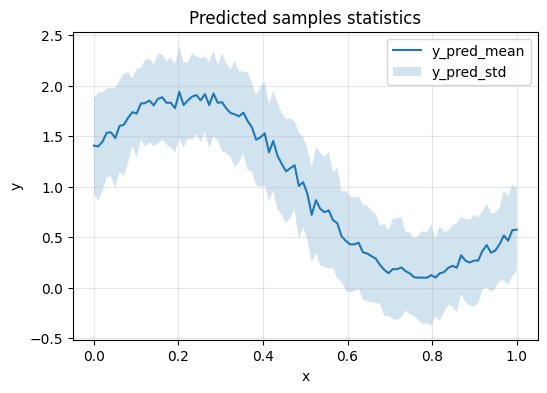

In [8]:
plt.figure(figsize=(6, 4))
plt.grid(alpha=0.3)
plt.xlabel('x')
plt.ylabel('y')
plt.title('Predicted samples')
for i in range(results.shape[0]):
    plt.scatter(locations[i]*torch.ones(num_samples), results[i], s=2, c='b', label='y_t')

# calculate the mean and std of the predicted samples
plt.figure(figsize=(6, 4))
plt.grid(alpha=0.3)
plt.xlabel('x')
plt.ylabel('y')
plt.title('Predicted samples statistics')
y_pred_mean = np.mean(results, axis=1)
y_pred_std = np.std(results, axis=1)
# plot the mean and std of the predicted samples
plt.plot(locations, y_pred_mean, label='y_pred_mean')
plt.fill_between(locations, y_pred_mean - y_pred_std, y_pred_mean + y_pred_std, alpha=0.2, label='y_pred_std')
plt.legend()

# Graveyard

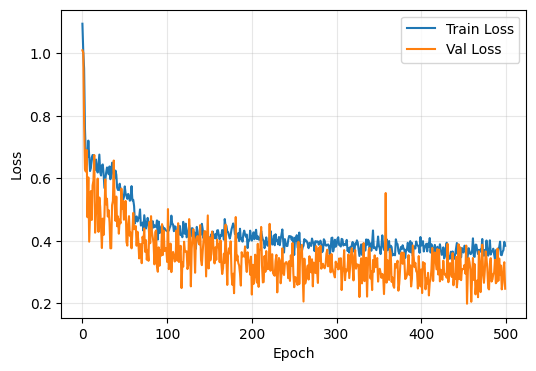

In [5]:
plt.figure(figsize=(6, 4))
plt.grid(alpha=0.3)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.plot(train_loss, label='Train Loss')
plt.plot(val_loss, label='Val Loss')
plt.legend()
plt.show()

In [7]:
num_locations = 200
x_locations = torch.linspace(0, 1, num_locations)
num_samples = 20
d = Diffusion(T=1000)
results = torch.zeros(num_locations,num_samples)

model.eval()
with torch.no_grad():
    with tqdm(range(len(x_locations))) as pbar:
        for i, location in enumerate(x_locations):
            x = torch.ones(num_samples) * location
            yt = torch.randn_like(x)
            for t in range(999,-1,-1):
                t_tensor = torch.ones(num_samples) * t
                score = model(x, yt, t_tensor)

                yt = (1/torch.sqrt(d.alphas[t])) * (yt - ((1-d.alphas[t+1])/torch.sqrt(1-d.alphas_cumprod[t+1])) * score)
                yt += torch.randn_like(yt) * torch.sqrt(d.betas[t+1])
            results[i] = yt
            pbar.update(1)

100%|██████████| 200/200 [00:20<00:00,  9.75it/s]


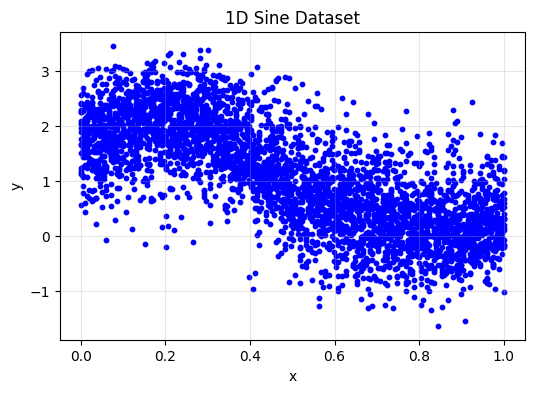

In [8]:
plt.figure(figsize=(6, 4))
plt.grid(alpha=0.3)
plt.xlabel('x')
plt.ylabel('y')
plt.title('1D Sine Dataset')
for i in range(results.shape[1]):
    plt.scatter(x_locations, results[:, i], s=10, c='b')
plt.show()


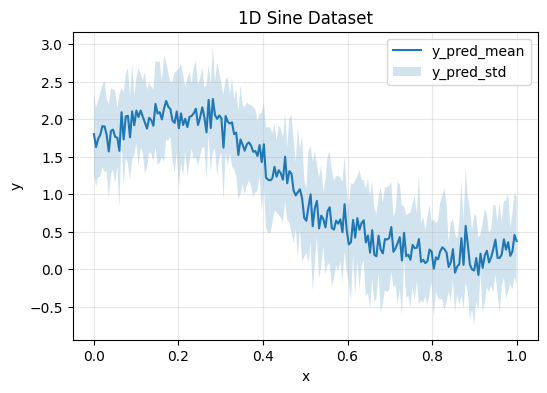

In [9]:
# calculate the mean of the y_pred
y_pred_mean = torch.mean(results, dim=1)
# calculate the std of the y_pred
y_pred_std = torch.std(results, dim=1)
# plot the y_pred
plt.figure(figsize=(6, 4))
plt.grid(alpha=0.3)
plt.xlabel('x')
plt.ylabel('y')
plt.title('1D Sine Dataset')
plt.plot(x_locations, y_pred_mean, label='y_pred_mean')
plt.fill_between(x_locations, y_pred_mean - y_pred_std, y_pred_mean + y_pred_std, alpha=0.2, label='y_pred_std')
plt.legend()
plt.show()